# Random Forest and GBDT On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Random Forest and GBDT algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import scipy 
import nltk
import time
import xgboost as xgb
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [5]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [9]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [7]:
sorted_data.shape

(364171, 12)

In [8]:
score = np.array(sorted_data.Score.reshape(364171,1))

## 5. Function Definitions

### 5.1 Data Spliting 

In [9]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, shuffle = False)    
    return train_x, test_x, train_y, test_y

### 5.2 Random Forest Classifier 

### [A] RF on Various Vectorizers

In [10]:
# applying random forest
def random_forest(X, Y, vectorizer, name):

    cv_err = []
    train_err = []
    num_base = np.arange(2, 30, 3)
    
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for base in num_base:
            
            if name in ['BoW','TFIDF']:
                
                vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=10) 
                clf.fit(train_vect, Y[train])
                
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
            elif name == 'Word2Vec':
                
                w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                train_vect = avg_w2v(X[train], w2v_model)
                cv_vect = avg_w2v(X[cv], w2v_model)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=10) 
                clf.fit(train_vect, Y[train])
                
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                
            else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_model = tf_idf_vect.fit(raw_x[train])
                #tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                tfidf_dict = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs = -1, max_depth=10) 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return train_err, cv_err

### [B] Error Curve

In [11]:
# comparing error between cv and train data
def error_comparision(cv_err, train_err):
    sns.set()
    num_base = np.arange(2, 30, 3)
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(num_base, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(num_base, train_err[i,:],label = 'train_error', color = 'b')
        plt.xlabel('Base-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [C] Accuracy Metrics

In [12]:
# plotting ROC curve along with confusion matrix
def final_test_acc(train_data, train_score, test_data, test_score, base, name):
    
    rf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=10)
    rf.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = rf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for num of base learners = '{0}' is '{1}'".format(base, acc_trn))
    ytrn_pred_proba = rf.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='RF', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('RF ROC curve for '+name+' with num of base learners '+str(base))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = rf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for num of base learners = '{0}' is '{1}'".format(base, acc))
    y_pred_proba = rf.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='RF', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('RF ROC curve for '+name+' with num of base learners '+str(base))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [D] Grid Search

In [13]:
# applying grid search to find best-fit number of base learners 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'n_estimators': np.arange(2, 30, 3)}]
            
    model = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1, max_depth=10), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [E] Overall Top Features

In [14]:
# finding top overall features 
def top_features_overall(data, score, vectorizer, top_n, base):

    data = scale(data, with_mean=False)
    clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=10)
    clf.fit(data, score)
    imp_features = clf.feature_importances_
    
    # sorting the weight indices 
    imp_sorted =  np.absolute(imp_features).argsort()[::-1]

    # top features
    imp = np.take(vectorizer.get_feature_names(), imp_sorted[:top_n])
    val = np.take(imp_features, imp_sorted[:top_n])
        
    # bar plot of important features
    sns.set()
    imp_plot = sns.barplot(imp, val, color="plum")
    imp_plot.set_xticklabels(imp, rotation=30)

    plt.ylabel('Importance')
    plt.xlabel('Variable') 
    plt.title('Overall Variable Importance');

### [F] Class-wise Top Features

In [36]:
def top_features_class_wise(X, Y, vectorizer, top_n, base):
    
    X = scale(X, with_mean=False)
    clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1)
    clf.fit(X, Y)
    imp_features = clf.feature_importances_

    output = np.zeros((2, len(imp_features)))
    for c in [0, 1]:
        cls = (Y==c)
        cls_list = []
        for i in cls:
            for j in i:
                cls_list.append(j)
        output[c] = (output[c].reshape((1,X.shape[1])) + np.multiply(np.mean(X[cls_list, :], axis=0),imp_features.reshape((1,X.shape[1]))))

    pos_class_sorted = output[1].argsort()[::-1]
    neg_class_sorted = -output[0].argsort()[::-1]
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_sorted[:top_n])
    for i in range(top_n):
        print(neg[i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_sorted[:top_n])
    for i in range(top_n):
        print(pos[i])

### [G] Tree Vislualization

In [15]:
# visualizing the tree and storing to png file 
from sklearn.tree import export_graphviz
from sklearn import tree
import pydot
from sklearn.externals.six import StringIO  
from IPython.display import Image  

def tree_visual(X, Y, vectorizer, base, name):
    
    rf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=10)
    rf.fit(X, Y)
    feature_list = vectorizer.get_feature_names()
    
    # pulling out one tree from the forest
    for i in range(base):
        base_tree = rf.estimators_[i]
        dot_file = name + '_tree' + str(i+1) + '.dot'
        png_file = name + '_tree' + str(i+1) + '.png'
        print(png_file)

        # exporting the image to a dot file
        export_graphviz(base_tree, out_file = dot_file, feature_names = feature_list)

        # using dot file to create a graph
        (graph, ) = pydot.graph_from_dot_file(dot_file)

        # writing graph to a png file
        graph.write_png(png_file)

### 5.3 XGBoost Classifier 

### [A] XGBoost on Various Vectorizers

In [37]:
# applying xgboost
def xg_boost(X, Y, vectorizer, name):

    cv_err = []
    train_err = []
    num_base = np.arange(2, 30, 3)
    depth = np.arange(2, 30, 3)
    
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for base in num_base:
            for d in depth:
            
                if name in ['BoW','TFIDF']:
                
                    vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                    train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                    cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1, scale_pos_weight=0.14) 
                    clf.fit(train_vect, Y[train])
                
                    train_err.append(1 - (clf.score(train_vect, Y[train])))
                    cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
                elif name == 'Word2Vec':
                
                    w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                    train_vect = avg_w2v(X[train], w2v_model)
                    cv_vect = avg_w2v(X[cv], w2v_model)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1, scale_pos_weight=0.14) 
                    clf.fit(train_vect, Y[train])
                
                    cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
                    train_err.append(1 - (clf.score(train_vect, Y[train])))
                
                else:
                    X1 = np.array(X)
                    raw_x = vectorizer
                    w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                    tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                    train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                    cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                    train_vect = np.nan_to_num(train_vect)
                    cv_vect = np.nan_to_num(cv_vect)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1, scale_pos_weight=0.14) 
                    clf.fit(standardizer(train_vect), Y[train])
                
                    cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                    train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return train_err, cv_err

### [B] Error Curve

In [21]:
# error curve surface plot 
from mpl_toolkits.mplot3d import Axes3D

def xgb_error_comparision(cv_err, train_err):
    
    num_base = np.arange(2, 30, 3)
    depth = np.arange(2, 30, 3)
    hypr = np.array([0,0])
    
    for i in num_base:
        for j in depth:
            hypr = np.vstack([hypr, np.array([i, j])])
    hypr = hypr[1:,:]
    
    for i in range(3):
        data_train = np.hstack([hypr, train_err[i,:].reshape(100,1)])
        df_train = pd.DataFrame(data_train)
        df_train.columns = ["# Base","Depth","Error"]
 
        # transforming the old column name in something numeric
        df_train['# Base'] = pd.Categorical(df_train['# Base'])
        df_train['# Base'] = df_train['# Base'].cat.codes
        
        ## plot for the train data
 
        # making the plot
        fig = plt.figure(figsize=(10, 7))
        fig.suptitle('Train Error for Fold ' + str(i + 1), fontsize = 18)
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        ax.set_xlabel('Num Of Base-Models')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Error')
 
        # adding a color bar which maps values to colors.
        surf=ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        fig.colorbar(surf, shrink=0.5, aspect=5)
 
        # rotation 
        ax.view_init(10, 60)
        plt.show()
        print('\n\n\n')
        
        ## plot for the cv data
        
        data_cv = np.hstack([hypr, cv_err[i,:].reshape(100,1)])
        df_cv = pd.DataFrame(data_cv)
        df_cv.columns = ["# Base","Depth","Error"]
 
        # And transform the old column name in something numeric
        df_cv['# Base'] = pd.Categorical(df_cv['# Base'])
        df_cv['# Base'] = df_cv['# Base'].cat.codes
 
        # making the plot
        fig = plt.figure(figsize=(10,7))
        fig.suptitle('CV Error for Fold ' + str(i + 1), fontsize = 18)
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        ax.set_xlabel('Num Of Base-Models')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Error')
 
        # adding a color bar which maps values to colors.
        surf=ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        fig.colorbar(surf, shrink=0.5, aspect=5)
 
        # rotation 
        ax.view_init(10, 60)
        plt.show()
        print('\n\n\n')

### [C] Accuracy Metrics

In [22]:
# plotting ROC curve along with confusion matrix
def xgb_final_test_acc(train_data, train_score, test_data, test_score, base, d, name):
    
    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1, scale_pos_weight=0.14)
    clf.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = clf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for num of base learners = '{0}' and depth = '{1}' is '{2}'".format(base, d, acc_trn))
    ytrn_pred_proba = clf.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='XGBoost', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('XGBoost ROC curve for '+name+' with num of base learners '+str(base)+' & depth '+str(d))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = clf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for num of base learners = '{0}' and depth = '{1}' is '{2}'".format(base, d, acc))
    y_pred_proba = clf.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='XGBoost', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('XGBoost ROC curve for '+name+' with num of base learners '+str(base)+' & depth '+str(d))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [D] Grid Search

In [58]:
# applying grid search to find best-fit number of base learners 
def xgb_grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'n_estimators': np.arange(2, 30, 3),
                  'max_depth': np.arange(2, 30, 3)}]
            
    model = GridSearchCV(xgb.XGBClassifier(n_jobs=-1, scale_pos_weight=0.14), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [E] Overall Top Features

In [24]:
# finding overall top features
def xgb_top_features_overall(data, score, vectorizer, top_n, base, d):

    data = scale(data, with_mean=False)
    clf = xgb.XGBClassifier(n_estimators = base, max_depth = d, n_jobs = -1, scale_pos_weight=0.14)
    clf.fit(data, score)
    imp_features = clf.feature_importances_
    
    # sorting the weight indices 
    imp_sorted =  imp_features.argsort()[::-1]

    # top features
    imp = np.take(vectorizer.get_feature_names(), imp_sorted[:top_n])
    val = np.take(imp_features, imp_sorted[:top_n])
        
    # bar plot of important features
    sns.set()
    plt.figure(figsize=(6,4))
    imp_plot = sns.barplot(imp, val, color="plum")
    imp_plot.set_xticklabels(imp, rotation=30)

    # axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable') 
    plt.title('Overall Variable Importance');

### [F] Tree Visualization

In [80]:
# creating the visual of the trees used 
from xgboost import plot_tree
from matplotlib.pylab import rcParams
def xgb_tree_visual(X, Y, vectorizer, base, d):
    
    clf = xgb.XGBClassifier(n_estimators = base, max_depth = d, n_jobs = -1, scale_pos_weight = 0.14)
    clf.fit(X, Y)

    #set up the parameters
    rcParams['figure.figsize'] = 80, 60
    plot_tree(clf, num_trees=1)

## 6. Bag of Words (BoW)

### 6.1 Random Forest on Bow

In [19]:
train_x, test_x, train_y, test_y = data_split(sorted_data[:100000], score[:100000])

In [20]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0)

In [21]:
# calculating cv-error and train error
train_err_bow, cv_err_bow = random_forest(train_x, train_y, count_vect, 'BoW')

In [22]:
cv_err = np.reshape(cv_err_bow,(3, 10))
train_err = np.reshape(train_err_bow,(3, 10))

### [A] Error Curve

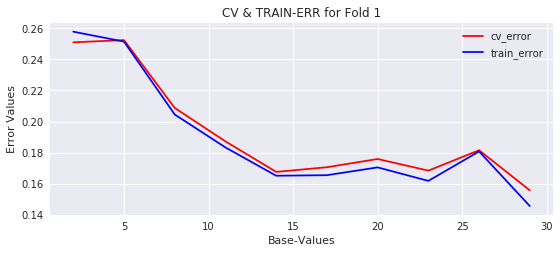

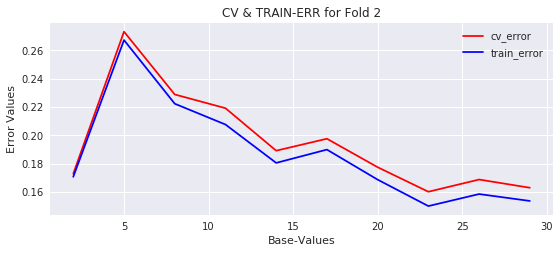

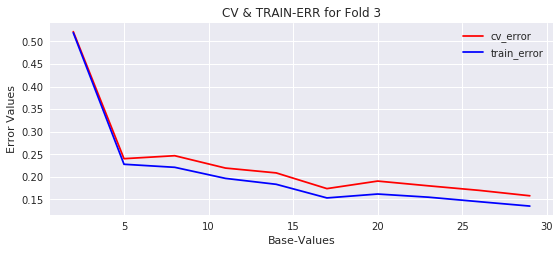

In [23]:
error_comparision(cv_err, train_err)

#### Observation:
* Best fit number of base learners seems to be near to 5.
* I have taken more numbers of base learners up to 30 show how the accuracy behaves at large base learners.
* We can notice here that, as number of base learners increases the gape between the train and cv error increases indicating model overfitting. 

In [24]:
# applying bow to test and train data 
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [B] Grid Search 

In [30]:
# finding best fit hyper parameters
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=29, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.8920931186544969


### [C] Accuracy Matrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '23' is '84.14857142857143'


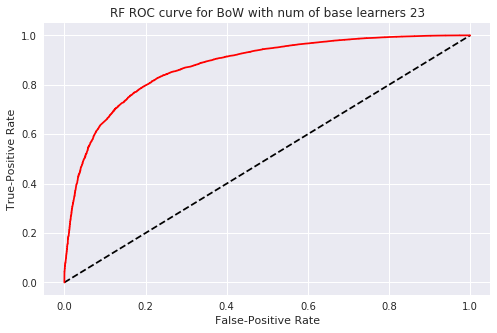

Area under the ROC curve is  0.877318118855503

Confusion Matrix :
 [[ 5902  2266]
 [ 8830 53002]]

Normalized Confusion Matrix :
 [[0.72257591 0.27742409]
 [0.14280631 0.85719369]]

Precision  : 40.06%, 95.90%
Recall     : 72.26%, 85.72%
F1-score   : [0.51545852 0.90524338]


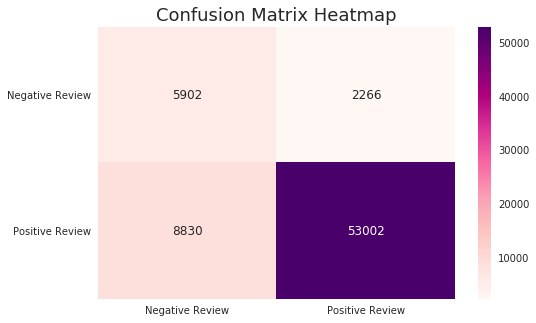







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '23' is '82.19333333333333'


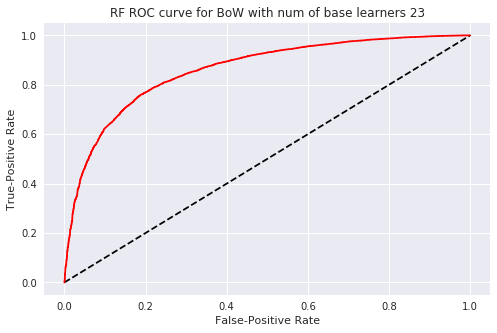

Area under the ROC curve is  0.8595135657634538

Confusion Matrix :
 [[ 2894  1209]
 [ 4133 21764]]

Normalized Confusion Matrix :
 [[0.70533756 0.29466244]
 [0.15959378 0.84040622]]

Precision  : 41.18%, 94.74%
Recall     : 70.53%, 84.04%
F1-score   : [0.52003594 0.89068958]


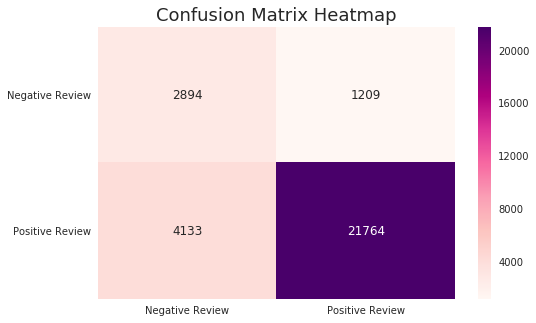

In [31]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 23, 'BoW')

### [D] Tree Visualization 

In [33]:
tree_visual(final_counts_train, train_y, count_vect, 4, 'BoW')

BoW_tree1.png
BoW_tree2.png
BoW_tree3.png
BoW_tree4.png


#### Base Estimator(tree) 1
![title](img/BoW_tree1.png)
#### Base Estimator(tree) 2
![title](img/BoW_tree2.png)
#### Base Estimator(tree) 3
![title](img/BoW_tree3.png)
#### Base Estimator(tree) 4
![title](img/BoW_tree4.png)

### [E] Overall Important Features

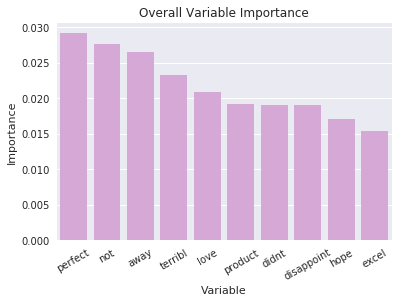

In [34]:
# printing overall top features(i.e words here)
top_features_overall(final_counts_train, train_y, count_vect, 10, 23)

### 6.2 XGBoost on BoW

In [61]:
# applying xgboost to BoW representaion  
train_err_bow, cv_err_bow = xg_boost(train_x, train_y, count_vect, 'BoW')

In [62]:
cv_err = np.reshape(cv_err_bow,(3, 100))
train_err = np.reshape(train_err_bow,(3, 100))

### [A] Error Curve 

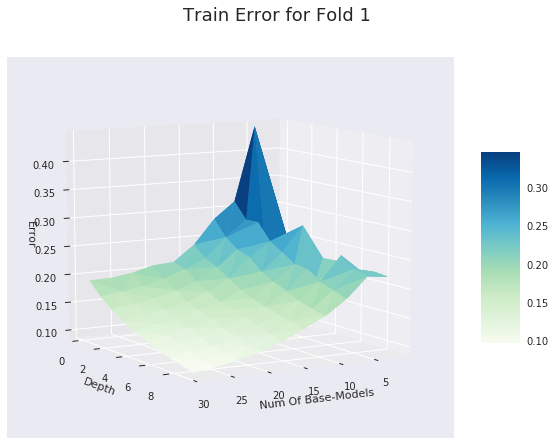

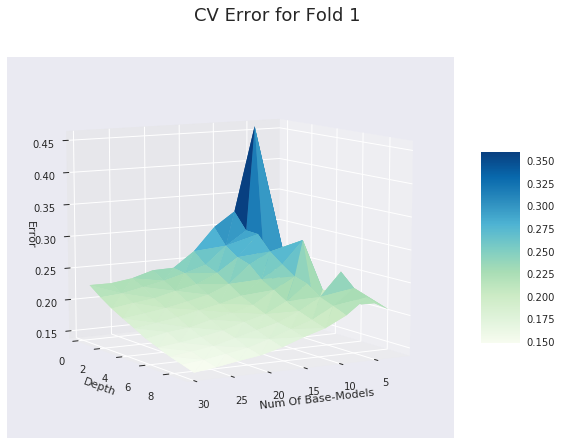

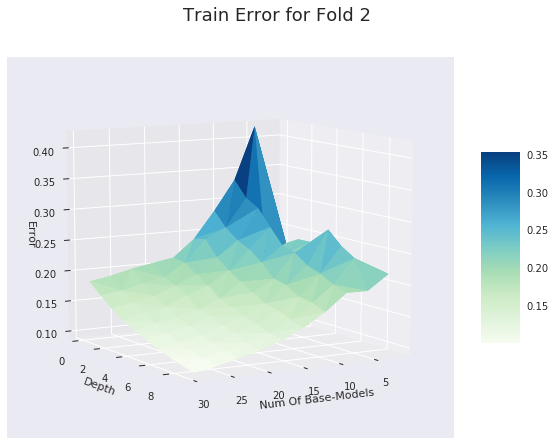

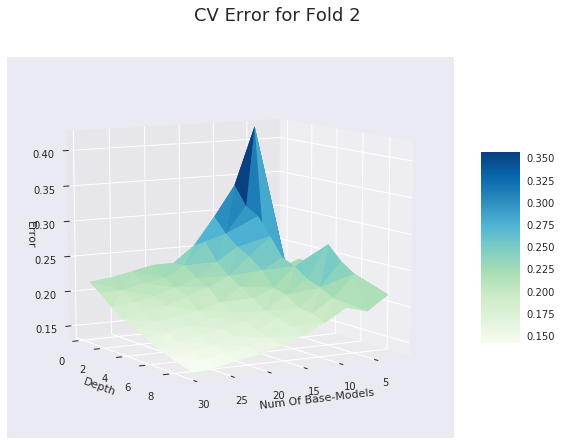

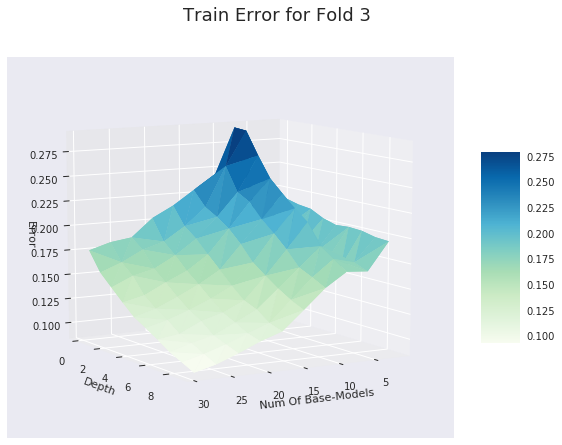

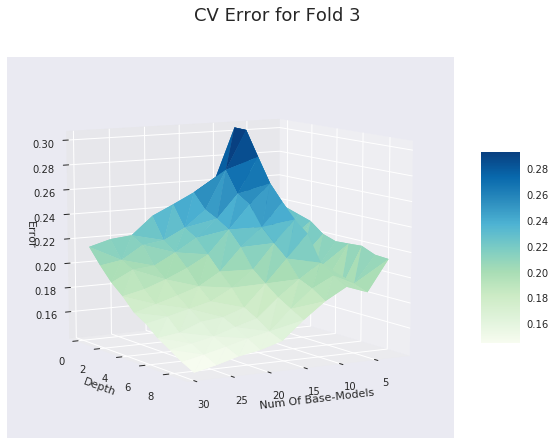

In [63]:
xgb_error_comparision(cv_err, train_err)

### [B] Grid Search 

In [66]:
# finding best fit hyper parameters
xgb_grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=29, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.14,
       seed=None, silent=True, subsample=1)
0.9126127577319588


### [C] Accuracy Matrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '10' is '82.68285714285715'


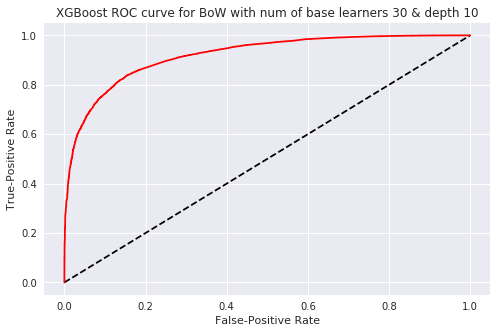

Area under the ROC curve is  0.9191126622259373

Confusion Matrix :
 [[ 7002  1166]
 [10956 50876]]

Normalized Confusion Matrix :
 [[0.8572478 0.1427522]
 [0.1771898 0.8228102]]

Precision  : 38.99%, 97.76%
Recall     : 85.72%, 82.28%
F1-score   : [0.53601776 0.89354901]


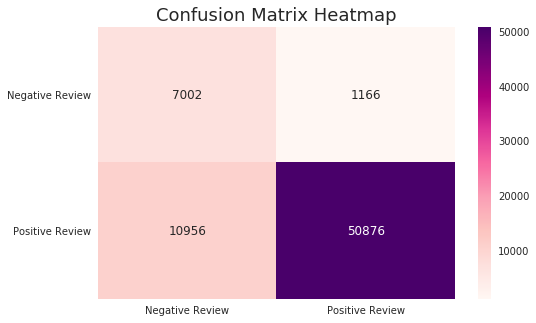







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '10' is '80.88333333333333'


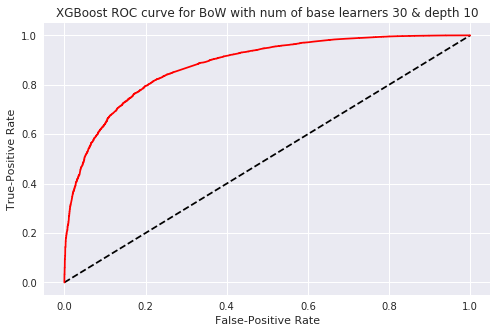

Area under the ROC curve is  0.8789318416794494

Confusion Matrix :
 [[ 3208   895]
 [ 4840 21057]]

Normalized Confusion Matrix :
 [[0.78186693 0.21813307]
 [0.18689423 0.81310577]]

Precision  : 39.86%, 95.92%
Recall     : 78.19%, 81.31%
F1-score   : [0.52802238 0.88014379]


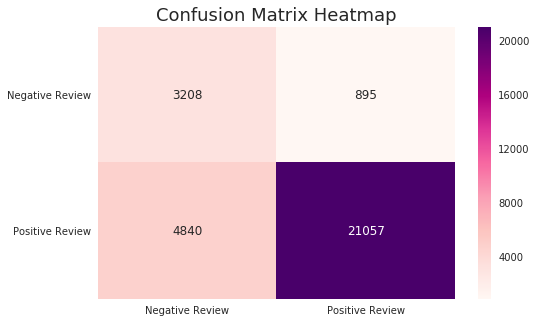

In [76]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 10, 'BoW')

### [D] Tree Visualization 

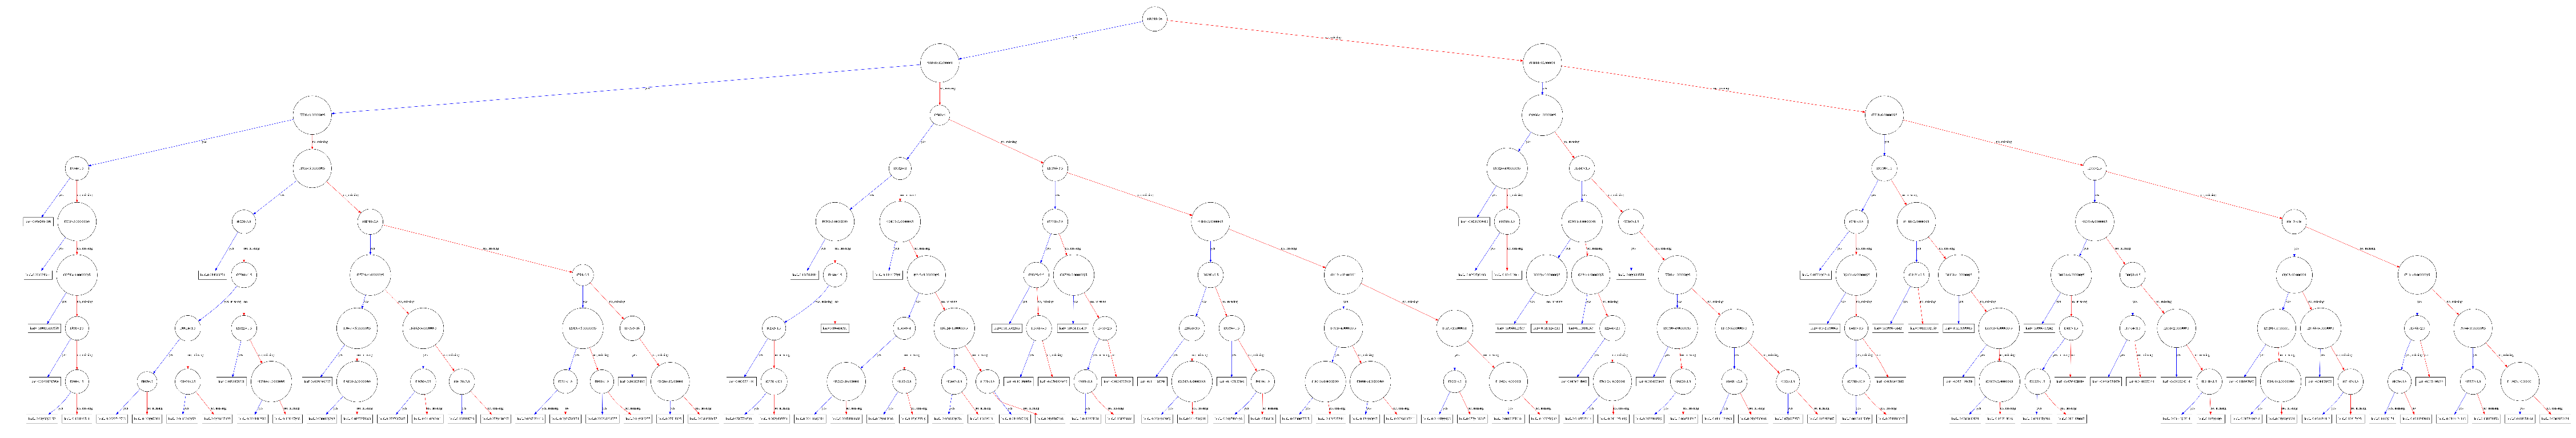

In [81]:
xgb_tree_visual(final_counts_train, train_y, count_vect, 30, 8)

### [E] Overall Top Features 

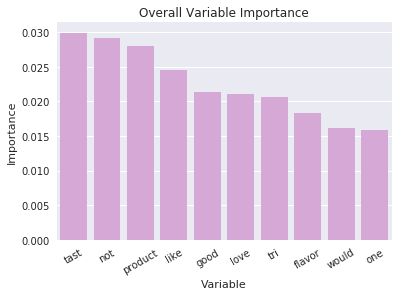

In [82]:
# printing top features(i.e words here)
xgb_top_features_overall(final_counts_train, train_y, count_vect, 10, 30, 10)

## 7. TFIDF 

### 7.1 Random Forest on TFIDF 

In [16]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(min_df=0)

In [39]:
# applying random forest
train_err, cv_err = random_forest(train_x, train_y, tf_idf_vect, 'TFIDF')

In [40]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

### [A] Error Curve

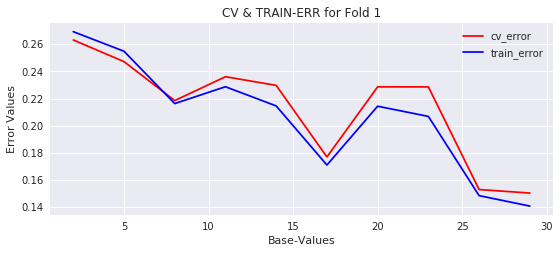

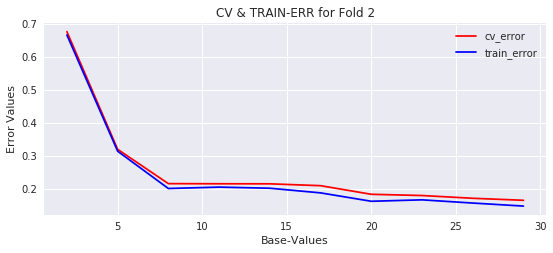

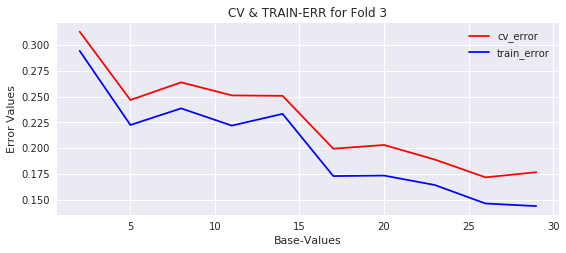

In [41]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

#### Observation:
* Best fit number of base learners seems to be near to 5.
* I have taken more numbers of base learners up to 30 show how the accuracy behaves at large base learners.
* We can notice here that, as number of base learners increases the gape between the train and cv error increases indicating model overfitting. 

In [42]:
# applying tfidf to test and train data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

### [B] Grid Search 

In [43]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=29, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.887403280718044


### [C] Accuracy Metrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '27' is '84.04'


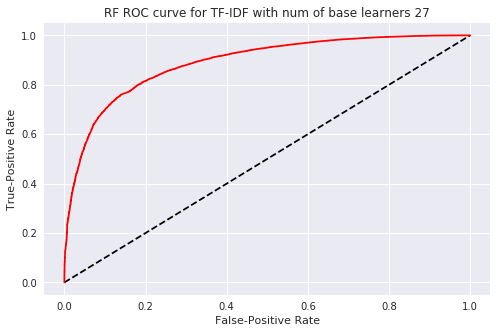

Area under the ROC curve is  0.8888440702217465

Confusion Matrix :
 [[ 6134  2034]
 [ 9138 52694]]

Normalized Confusion Matrix :
 [[0.75097943 0.24902057]
 [0.14778755 0.85221245]]

Precision  : 40.17%, 96.28%
Recall     : 75.10%, 85.22%
F1-score   : [0.52337884 0.90415237]


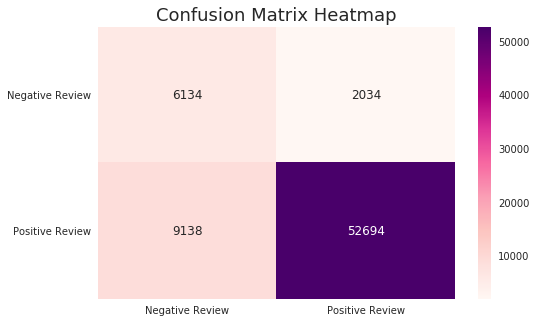







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '27' is '81.69333333333333'


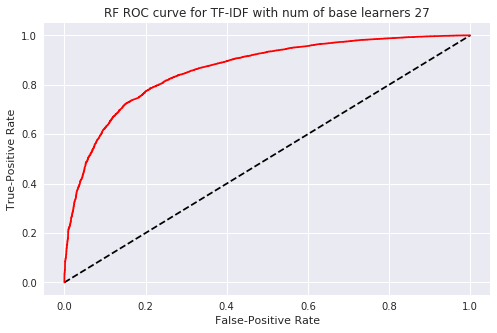

Area under the ROC curve is  0.8627472040453928

Confusion Matrix :
 [[ 3003  1100]
 [ 4392 21505]]

Normalized Confusion Matrix :
 [[0.73190349 0.26809651]
 [0.16959493 0.83040507]]

Precision  : 40.61%, 95.13%
Recall     : 73.19%, 83.04%
F1-score   : [0.52235171 0.88676756]


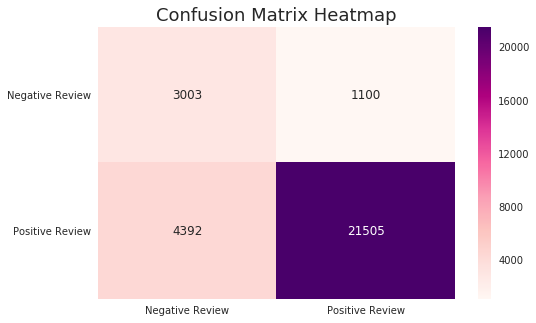

In [47]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 27, 'TF-IDF')

### [D] Tree Visualization 

In [48]:
# tree visualization 
tree_visual(final_counts_train, train_y, tf_idf_vect, 4, 'TFIDF')

TFIDF_tree1.png
TFIDF_tree2.png
TFIDF_tree3.png
TFIDF_tree4.png


#### Base Estimator(tree) 1
![title](img/TFIDF_tree1.png)
#### Base Estimator(tree) 2
![title](img/TFIDF_tree2.png)
#### Base Estimator(tree) 3
![title](img/TFIDF_tree3.png)
#### Base Estimator(tree) 4
![title](img/TFIDF_tree4.png)

### [E] Overall Top Features

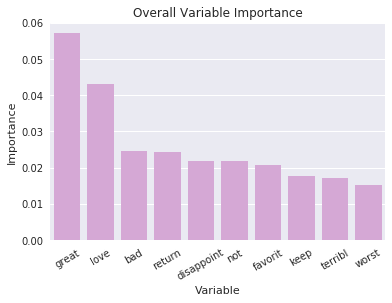

In [49]:
# printing top features(i.e words here)
top_features_overall(final_counts_train, train_y, tf_idf_vect, 10, 27)

### 7.2 XGBoost on TFIDF 

In [85]:
# applying xgboost on tfidf
train_err_tfidf, cv_err_tfidf = xg_boost(train_x, train_y, tf_idf_vect, 'TFIDF')

In [86]:
cv_err = np.reshape(cv_err_tfidf,(3, 100))
train_err = np.reshape(train_err_tfidf,(3, 100))

### [A] Error Curve

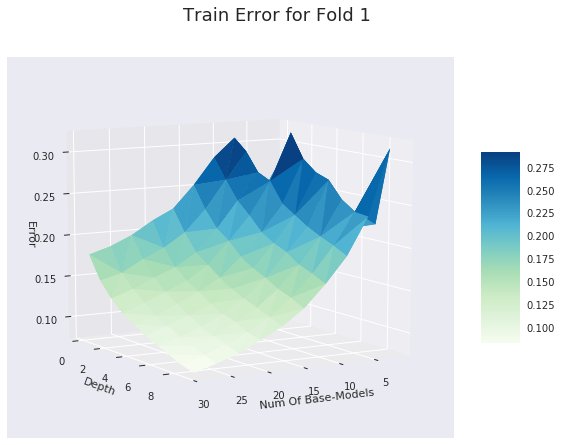

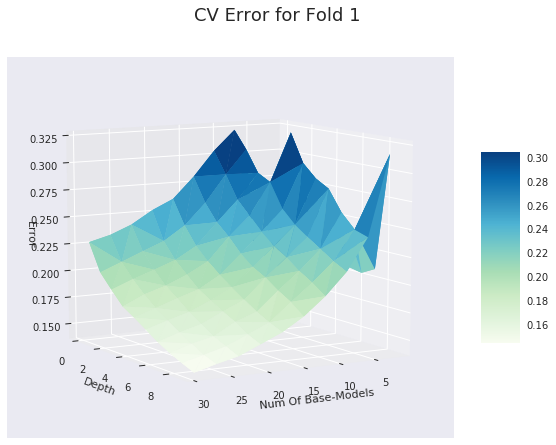

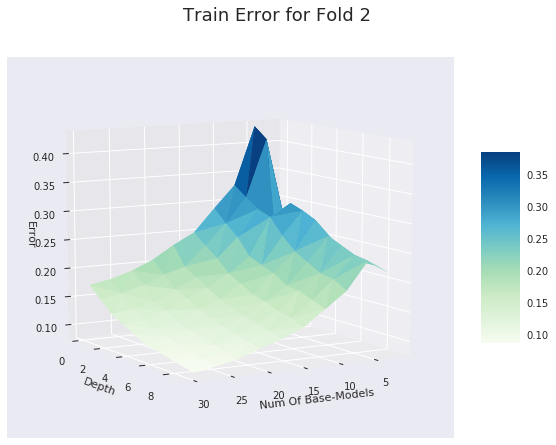

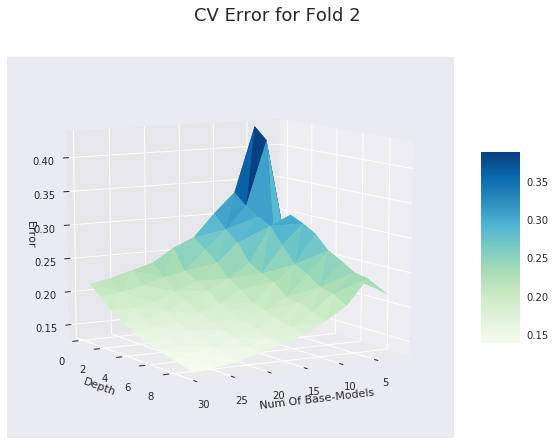

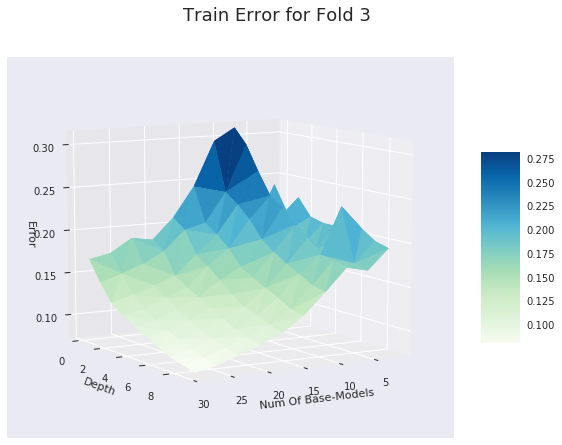

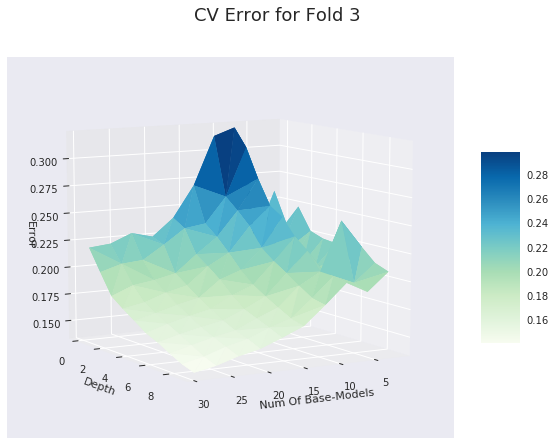

In [87]:
xgb_error_comparision(cv_err, train_err)

### [B] Grid Search

In [47]:
# finding best fit hyper parameters
xgb_grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=29, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.9435653424809117


### [C] Accuracy Metrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '10' is '82.65714285714286'


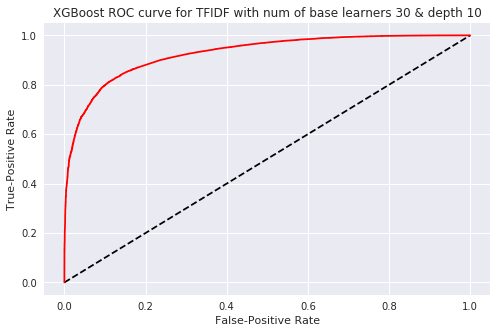

Area under the ROC curve is  0.926366245329197

Confusion Matrix :
 [[ 7199   969]
 [11171 50661]]

Normalized Confusion Matrix :
 [[0.88136631 0.11863369]
 [0.18066697 0.81933303]]

Precision  : 39.19%, 98.12%
Recall     : 88.14%, 81.93%
F1-score   : [0.54254277 0.89300383]


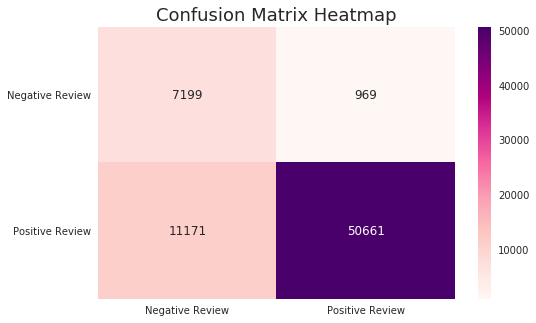







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '10' is '80.47666666666666'


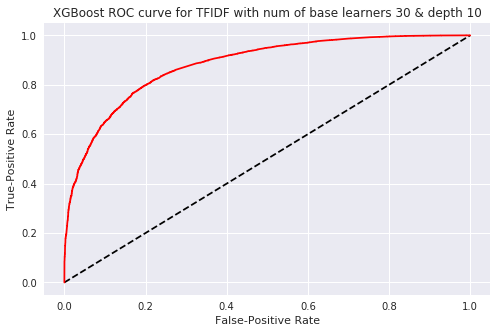

Area under the ROC curve is  0.8812264876047561

Confusion Matrix :
 [[ 3237   866]
 [ 4991 20906]]

Normalized Confusion Matrix :
 [[0.78893493 0.21106507]
 [0.19272503 0.80727497]]

Precision  : 39.34%, 96.02%
Recall     : 78.89%, 80.73%
F1-score   : [0.52501825 0.87713189]


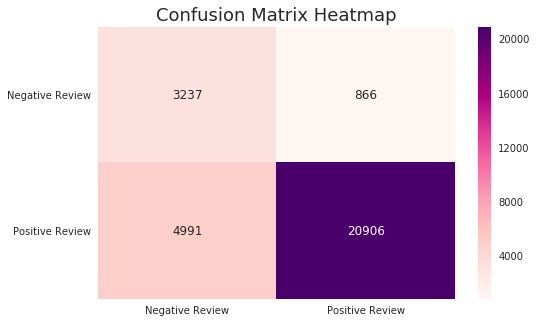

In [95]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 10, 'TFIDF')

### [D] Tree Visualization 

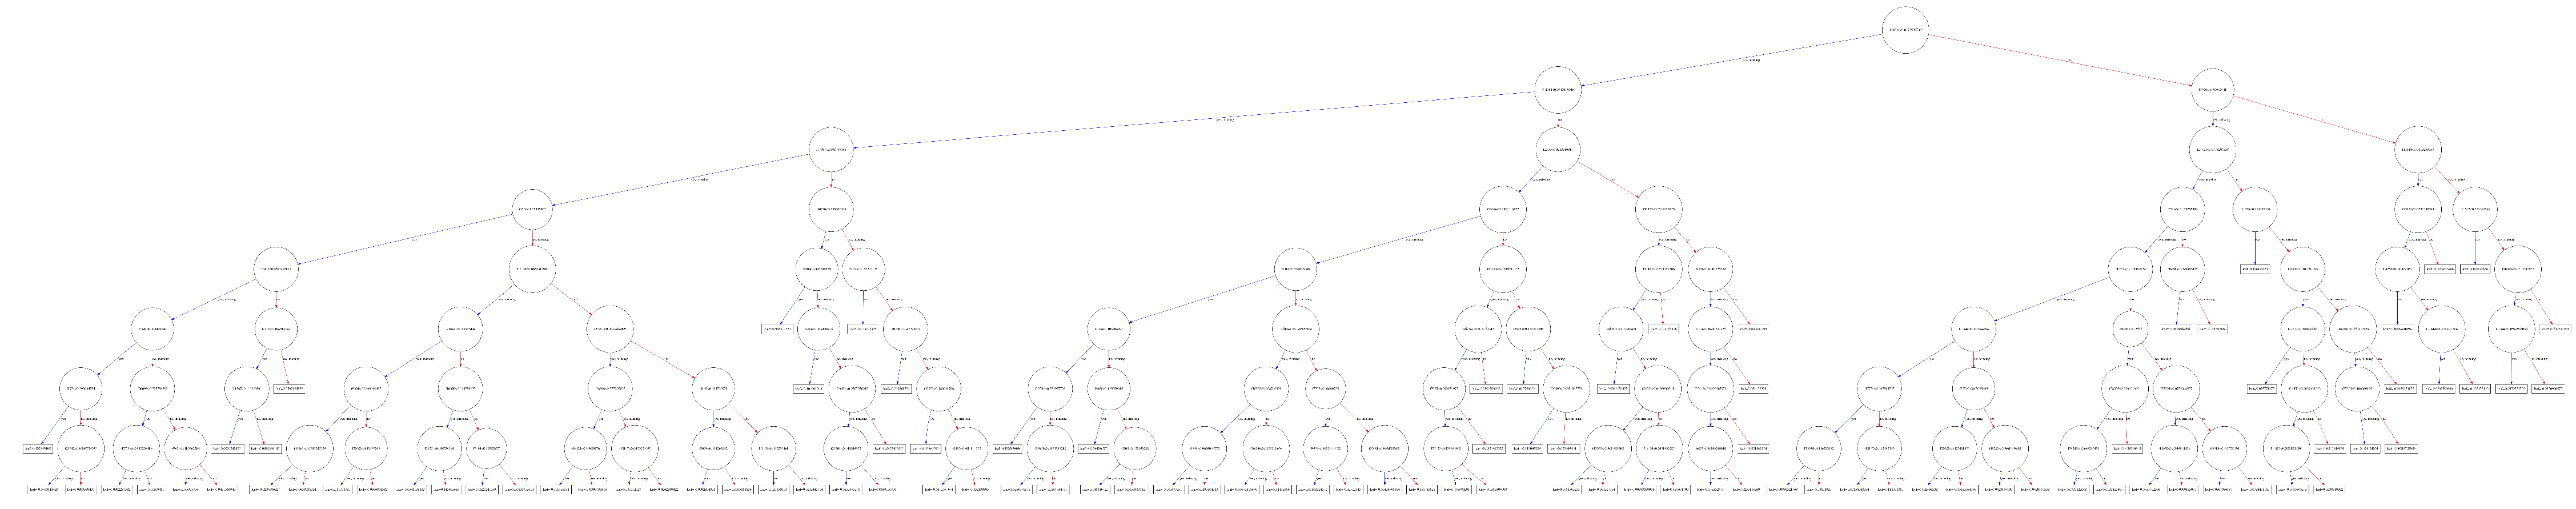

In [96]:
xgb_tree_visual(final_counts_train, train_y, count_vect, 30, 8)

### [E] Overall Top Features

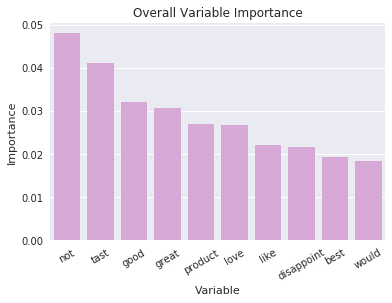

In [97]:
# printing top features(i.e words here)
xgb_top_features_overall(final_counts_train, train_y, tf_idf_vect, 10, 30, 10)

## 8. Word2Vec 

In [17]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [18]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [19]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [53]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


### 8.1 Random Forest on Avg Word2Vec

In [20]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [55]:
train_x, test_x, train_y, test_y = data_split(list_of_sent[:100000], score[:100000])

In [56]:
# applying random forest
train_err, cv_err = random_forest(np.array(train_x), np.array(train_y), None, 'Word2Vec')

In [57]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

### [A] Error Curve

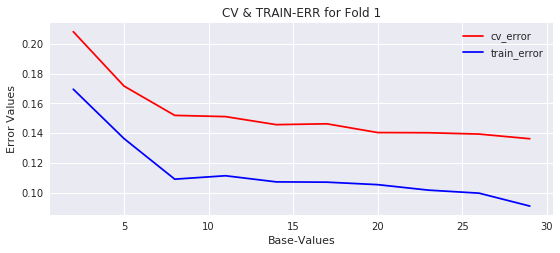

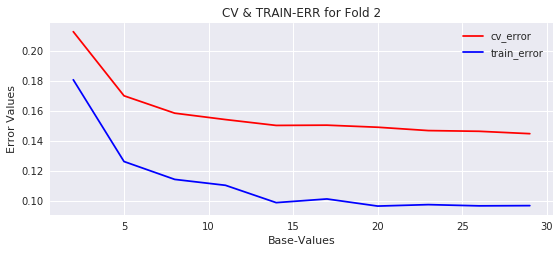

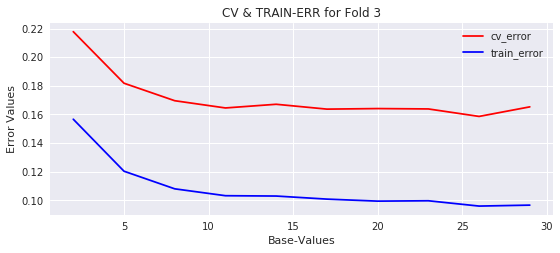

In [58]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

#### Observation:
* Best fit number of base learners seems to be near to 5.
* I have taken more numbers of base learners up to 30 show how the accuracy behaves at large base learners.
* We can notice here that, as number of base learners increases the gape between the train and cv error increases indicating model overfitting. 

In [59]:
# applying w2v to train and test data
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

In [60]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [B] Grid Search

In [92]:
# finding best fit num of estimator 
grid_search_cv(train_vect, train_y, test_vect, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.9312126800942242


### [C] Accuracy Metrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '5' is '86.02285714285715'


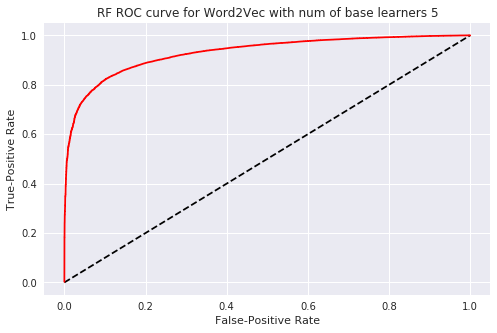

Area under the ROC curve is  0.9299300552116893

Confusion Matrix :
 [[ 6931  1237]
 [ 8547 53285]]

Normalized Confusion Matrix :
 [[0.84855534 0.15144466]
 [0.1382294  0.8617706 ]]

Precision  : 44.78%, 97.73%
Recall     : 84.86%, 86.18%
F1-score   : [0.58623023 0.91591179]


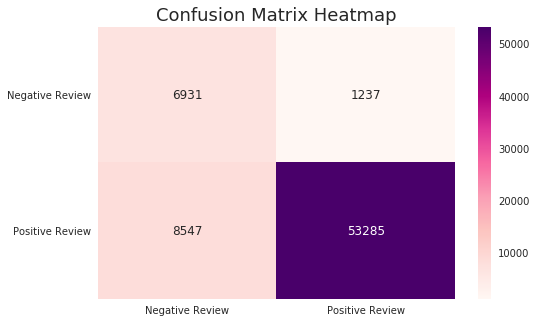







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '5' is '80.15666666666667'


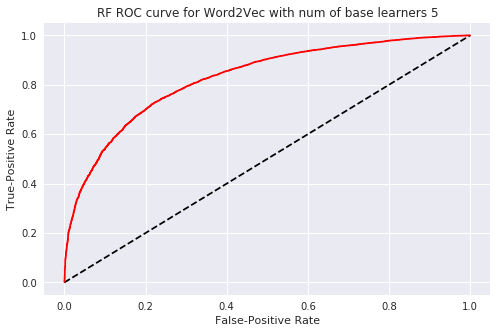

Area under the ROC curve is  0.8281105473509575

Confusion Matrix :
 [[ 2665  1438]
 [ 4515 21382]]

Normalized Confusion Matrix :
 [[0.64952474 0.35047526]
 [0.17434452 0.82565548]]

Precision  : 37.12%, 93.70%
Recall     : 64.95%, 82.57%
F1-score   : [0.47239209 0.87780446]


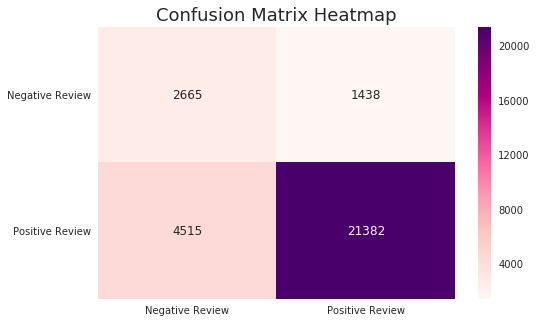

In [61]:
# accuracy measures for train and test data
final_test_acc(train_vect, train_y, test_vect, test_y, 5, 'Word2Vec')

### 8.2 XGBoost on Avg Word2Vec

In [98]:
train_err, cv_err = xg_boost(np.array(train_x), np.array(train_y), None, 'Word2Vec')

In [99]:
cv_err = np.reshape(cv_err,(3, 100))
train_err = np.reshape(train_err,(3, 100))

### [A] Error Curve

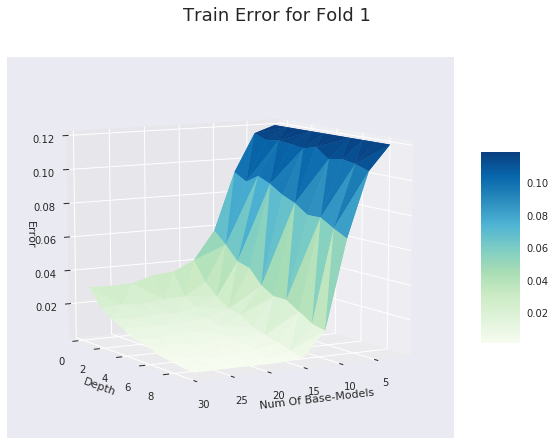

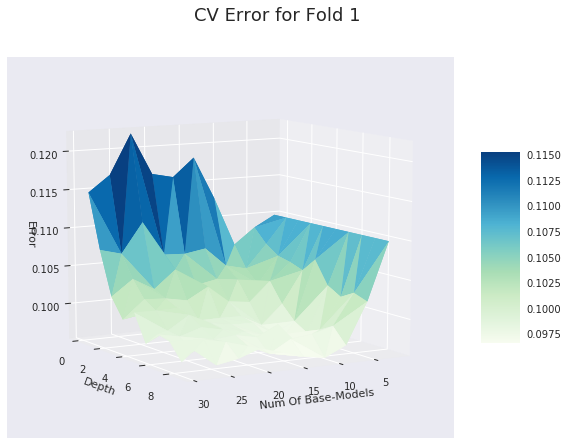

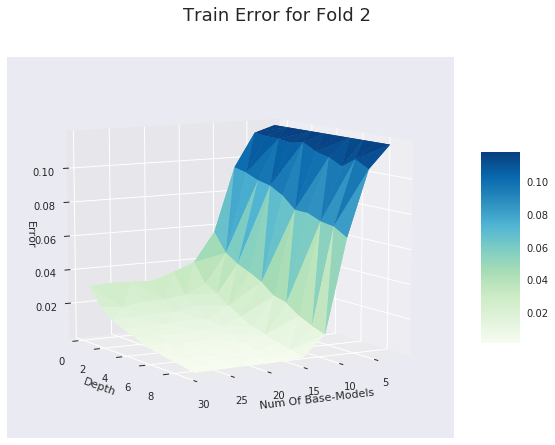

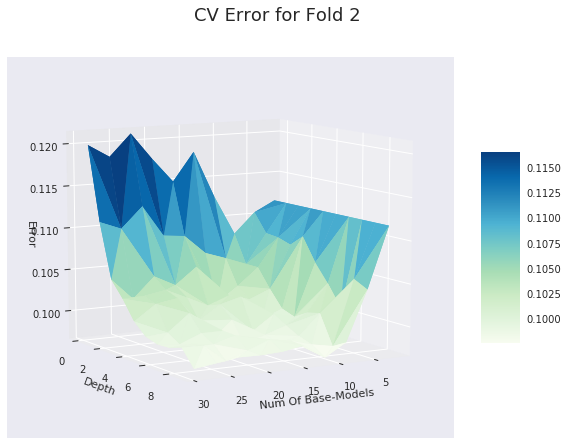

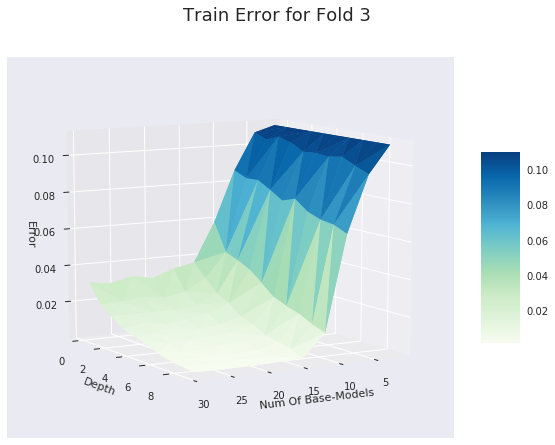

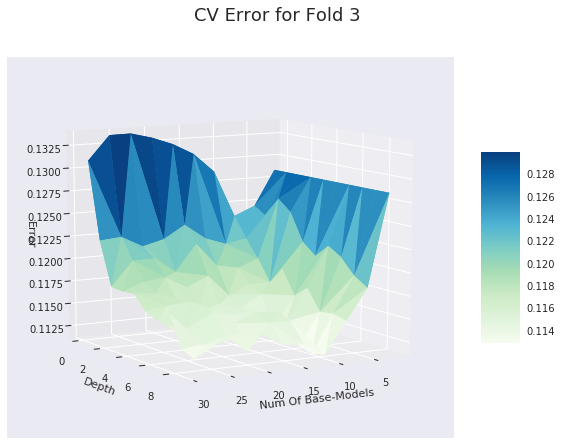

In [100]:
xgb_error_comparision(cv_err, train_err)

### [B] Grid Search

In [101]:
# finding best fit hyper parameters
xgb_grid_search_cv(train_vect, train_y, test_vect, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.935200308307794


### [C] Accuracy Metrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '14' is '86.03857142857143'


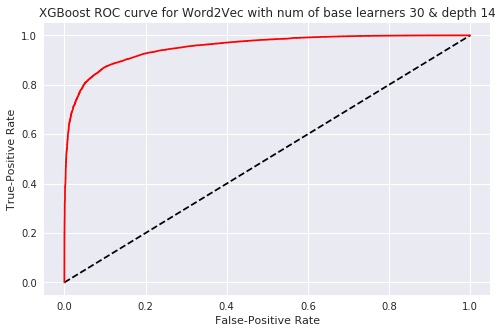

Area under the ROC curve is  0.9522313626136044

Confusion Matrix :
 [[ 7472   696]
 [ 9077 52755]]

Normalized Confusion Matrix :
 [[0.91478942 0.08521058]
 [0.14680101 0.85319899]]

Precision  : 45.15%, 98.70%
Recall     : 91.48%, 85.32%
F1-score   : [0.60460412 0.91522601]


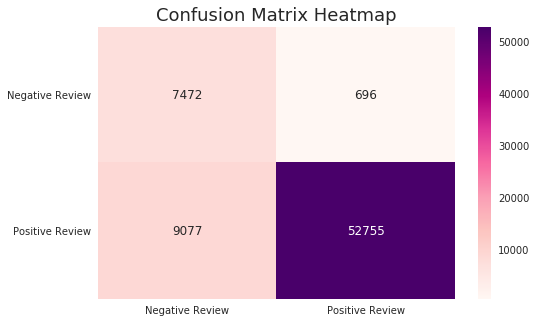







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '14' is '82.78666666666666'


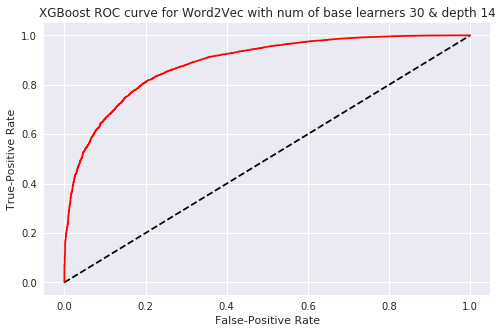

Area under the ROC curve is  0.8868654438436917

Confusion Matrix :
 [[ 3160   943]
 [ 4221 21676]]

Normalized Confusion Matrix :
 [[0.77016817 0.22983183]
 [0.16299185 0.83700815]]

Precision  : 42.81%, 95.83%
Recall     : 77.02%, 83.70%
F1-score   : [0.5503309  0.89356089]


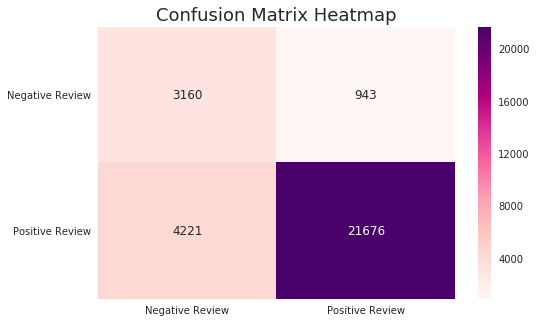

In [111]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 14, 'Word2Vec')

## 9. TF-IDF weighted Word2Vec

In [25]:
# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, dictionary):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in data: 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = dictionary[word] * (sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

### 9.1 Random Forest on TFIDF weighted Word2Vec

In [23]:
train_x, test_x, train_y, test_y, train_x_in_list, test_x_in_list = train_test_split(list_of_sent[:100000], score[:100000], sorted_data.CleanedText[:100000].values,
                                                                 test_size=0.3, shuffle=False)

In [26]:
train_err, cv_err = random_forest(train_x, train_y, train_x_in_list, 'TFIDF-W2V')

In [27]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

### [A] Error Curve

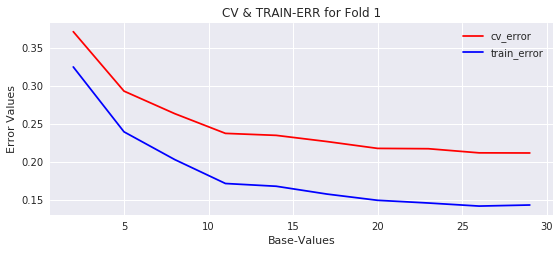

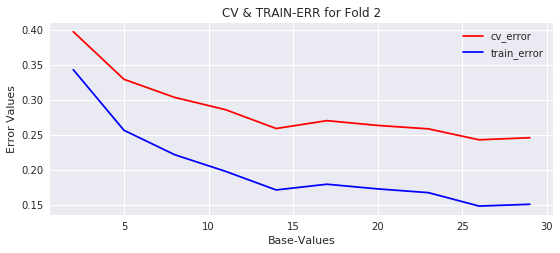

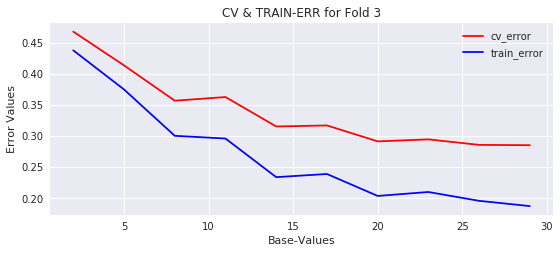

In [27]:
error_comparision(cv_err, train_err)

#### Observation:
* Best fit number of base learners seems to be near to 5.
* I have taken more numbers of base learners up to 30 show how the accuracy behaves at large base learners.
* We can notice here that, as number of base learners increases the gape between the train and cv error increases indicating model overfitting. 

In [28]:
# applying tf-idf weighted w2v to train and test set 
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=-1)
tfidf_model = tf_idf_vect.fit_transform(train_x_in_list)
tfidf_dict = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
train_vect = tfidf_w2v(list_of_sent[:70000], w2v_model, tfidf_dict)
test_vect = tfidf_w2v(list_of_sent[70000:100000], w2v_model, tfidf_dict)

In [29]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [B] Grid Search

In [137]:
# finding best-fit depth and number of estimator using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=23, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.9272304666547471


### [C] Accuracy Metrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '2' is '69.47142857142858'


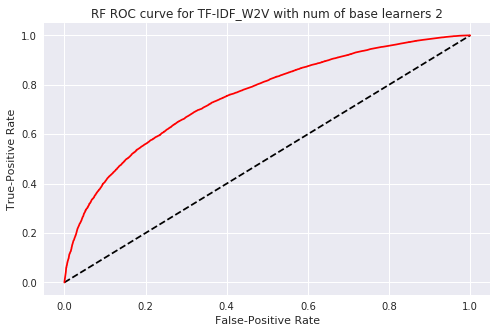

Area under the ROC curve is  0.752028044990698

Confusion Matrix :
 [[ 5480  2688]
 [18682 43150]]

Normalized Confusion Matrix :
 [[0.67091087 0.32908913]
 [0.30214129 0.69785871]]

Precision  : 22.68%, 94.14%
Recall     : 67.09%, 69.79%
F1-score   : [0.33900402 0.80152317]


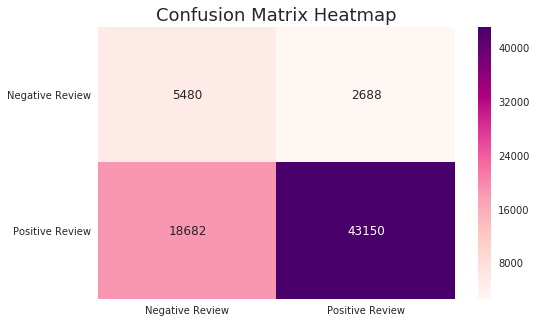







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '2' is '64.61666666666666'


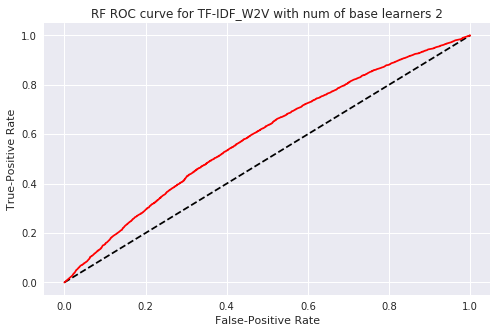

Area under the ROC curve is  0.5911681318833037

Confusion Matrix :
 [[ 1864  2239]
 [ 8376 17521]]

Normalized Confusion Matrix :
 [[0.45430173 0.54569827]
 [0.32343515 0.67656485]]

Precision  : 18.20%, 88.67%
Recall     : 45.43%, 67.66%
F1-score   : [0.25991773 0.76750553]


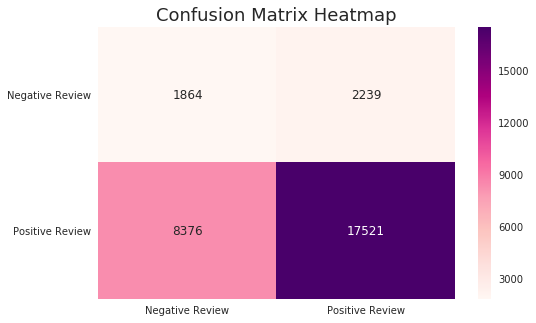

In [31]:
final_test_acc(train_vect, train_y, test_vect, test_y, 2, 'TF-IDF_W2V')

### 9.2 XGBoost on TFIDF weighted Word2Vec

In [40]:
train_err_tfw2v, cv_err_tfw2v = xg_boost(train_x, train_y, raw_x, 'TFIDF-W2V')

In [41]:
cv_err = np.reshape(cv_err_tfw2v,(3, 100))
train_err = np.reshape(train_err_tfw2v,(3, 100))

### [A] Error Curve

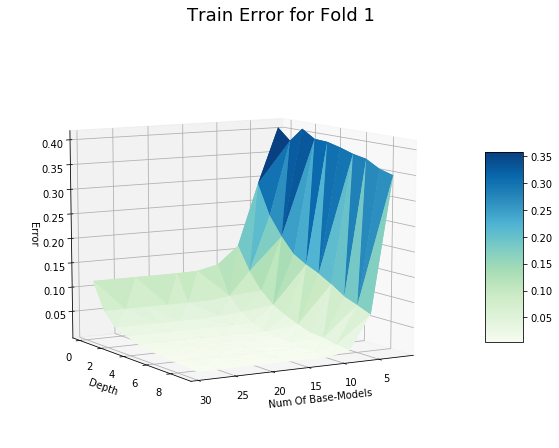

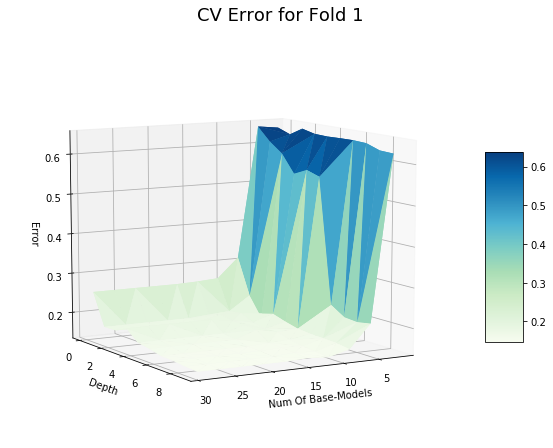

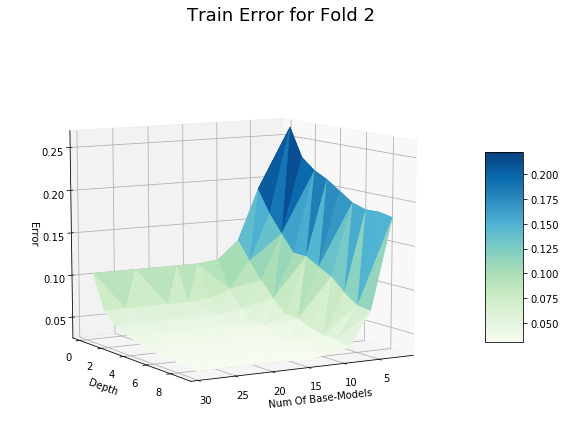

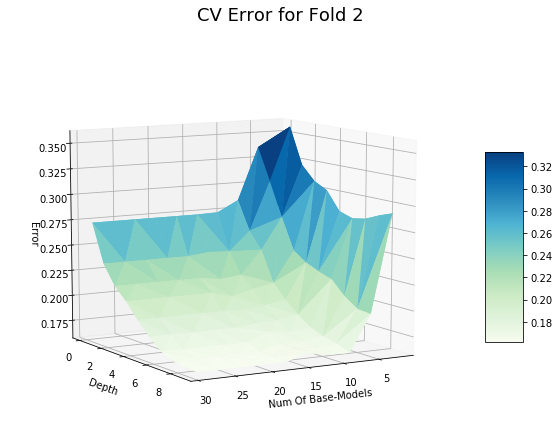

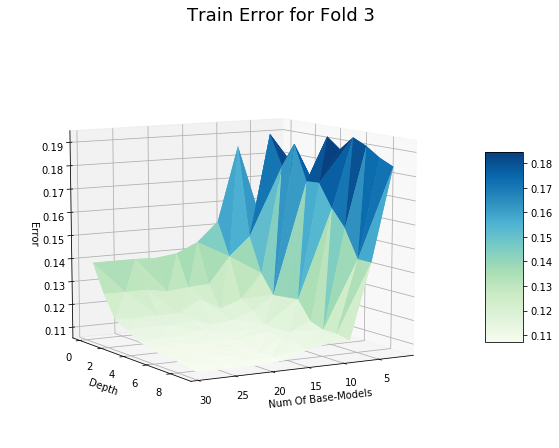

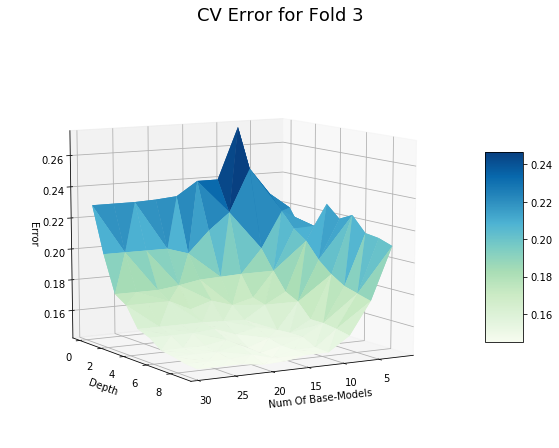

In [42]:
xgb_error_comparision(cv_err, train_err)

### [B] Grid Search

In [45]:
xgb_grid_search_cv(train_vect, train_y, test_vect, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=23,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.9145430579964852


### [C] Accuracy Metrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '15' and depth = '7' is '77.56285714285714'


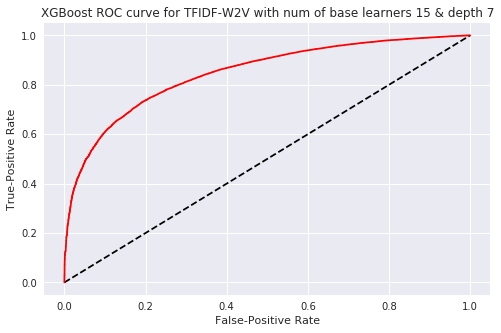

Area under the ROC curve is  0.846513088204061

Confusion Matrix :
 [[ 6122  2046]
 [13660 48172]]

Normalized Confusion Matrix :
 [[0.74951028 0.25048972]
 [0.22092121 0.77907879]]

Precision  : 30.95%, 95.93%
Recall     : 74.95%, 77.91%
F1-score   : [0.43806798 0.85983043]


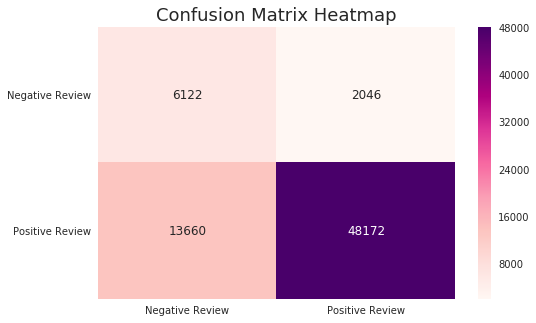







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '15' and depth = '7' is '76.29333333333334'


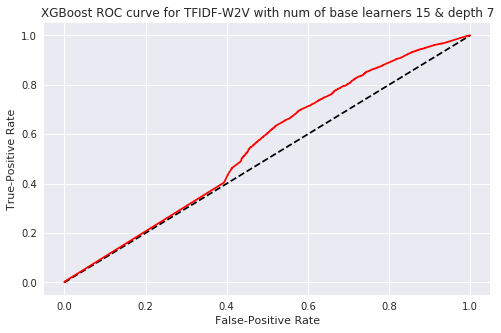

Area under the ROC curve is  0.5524988421528655

Confusion Matrix :
 [[ 1079  3024]
 [ 4088 21809]]

Normalized Confusion Matrix :
 [[0.26297831 0.73702169]
 [0.15785612 0.84214388]]

Precision  : 20.88%, 87.82%
Recall     : 26.30%, 84.21%
F1-score   : [0.23279396 0.85980682]


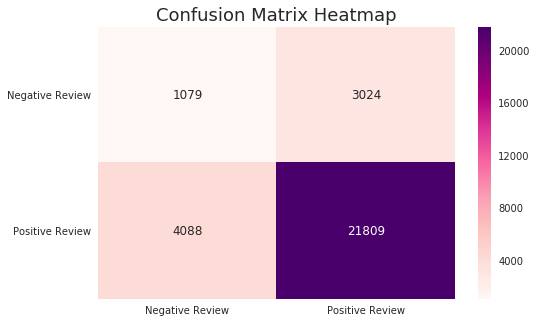

In [57]:
xgb_final_test_acc(train_vect, train_y, test_vect, test_y, 15, 7, 'TFIDF-W2V')

## 10. Summary

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5. Then I applied some pre-processing methods to make data best fit to apply Random Forest and XGBoost. After that I have declared some useful functions to modularize the whole process. For our end goal i.e to classify a review whether it is positive or not by using Random Forest and XGBoost, we need to convert the textual data to numerial one. To do so i have used these four(given below) vectorization methods.<br>
</p>
<br>
1. Bag of Words(BoW)<br>
2. TF-IDF<br>
3. Avg Word2Vec<br>
4. TF-IDF W2V
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before applying any model to our data we need to split the data into train and test set. Here I have taken 70% of the data(100000 datapoints) as train-set and rest 30% as test-data. The important part here is "I have sorted the data in ascending order of time stamp of the reviews" and then splitted the whole data without shuffling it. The only problem with this data set is that it is a imbalanced dataset i.e there is a mismatch between number of instances of each class. Here i'm having 87729 positive data-points and 12271 negative data-points. It means the given dataset is nearly 87.7% positive & 12.3% negative. 
</p>

<h3> Results:</h3>
<br>
<h3> [A] Random Forest </h3>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Random Forest we have got number of base estimators which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit number of base estimators, I have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW representation, we got best-fit number of base estimators = 23 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking number of base estimators = 23, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>23</td>
    <td>84.14%</td>
    <td>40.06%, 95.90%</td>
    <td>72.26%, 85.72%</td>
    <td>0.51 0.90</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>23</td>
    <td>82.2%</td>
    <td>41.18%, 94.74%</td>
    <td>70.53%, 84.04%</td>
    <td>0.52 0.89</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 84.14% accuracy for train-data and 82.2% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit number of base estimators = 27 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of base estimators = 27, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>27</td>
    <td>84.04%</td>
    <td>40.17%, 96.28%</td>
    <td>75.10%, 85.22%</td>
    <td>0.52 0.90</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>27</td>
    <td>81.7%</td>
    <td>40.61%, 95.13%</td>
    <td>73.19%, 83.04%</td>
    <td>0.52 0.88</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 84.04% accuracy with high positive F1-Scores for train-data and 81.7% for test-data. But for test-data, negative class F1-Score is 0.52 which is too low compared to positive class F1-Score 0.88. TF-IDF performed similar to the BoW.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. Avg Word2Vec</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit number of base estimators = 5 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of base estimators = 5, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>5</td>
    <td>86.02%</td>
    <td>44.78%, 97.73%</td>
    <td>84.86%, 86.18%</td>
    <td>0.58 0.91</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>5</td>
    <td>80.15%</td>
    <td>37.12%, 93.70%</td>
    <td>64.95%, 82.57%</td>
    <td>0.47 0.87</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 86.02% accuracy with high F1-Scores for train-data and 80.15% for test-data. But for test-data, negative class F1-Score is poor i.e 0.47 which is too low compared to positive class F1-Score 0.87.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>4. TF-IDF W2V</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit number of estimators = 2 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of estimators = 2, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>2</td>
    <td>69.5%</td>
    <td>22.68%, 94.14%</td>
    <td>67.09%, 69.79%</td>
    <td>0.34 0.80</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>2</td>
    <td>64.6%</td>
    <td>18.20%, 88.67%</td>
    <td>45.43%, 67.66%</td>
    <td>0.26 0.76</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 69.5% accuracy with bad F1-Score for train-data and 64.6% for test-data. But for test-data, negative class F1-Score is very poor i.e 0.26 which is the worst one till now.<br>
<br>
<h3> [B] XGBoost </h3>
<br>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In XGBoost we have got number of base estimators and depth which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit number of base estimators, I have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW representation, we got best-fit number of base estimators = 30 and depth = 10 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking number of base estimators = 30 and depth = 10, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>30</td>
    <td>10</td>
    <td>82.7%</td>
    <td>38.99%, 97.76%</td>
    <td>85.72%, 82.28%</td>
    <td>0.53 0.89</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>30</td>
    <td>10</td>  
    <td>80.8%</td>
    <td>39.86%, 95.92%</td>
    <td>78.19%, 81.31%</td>
    <td>0.53 0.88</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 82.7% accuracy for train-data and 80.8% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit number of base estimators = 30 and depth = 10 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of base estimators = 30 and depth = 10, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>30</td>
    <td>10</td>
    <td>82.6%</td>
    <td>39.19%, 98.12%</td>
    <td>88.14%, 81.93%</td>
    <td>0.54 0.89</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>30</td>
    <td>10</td>
    <td>80.5%</td>
    <td>39.34%, 96.02%</td>
    <td>78.89%, 80.73%</td>
    <td>0.52 0.87</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 82.6% accuracy with reasonable F1-Scores for train-data and 80.5% for test-data. But for test-data, negative class F1-Score is 0.52 which is low compared to positive class F1-Score 0.87. TF-IDF performed similar to the BoW.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. Avg Word2Vec</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit number of base estimators = 30 and depth = 14 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of base estimators = 30 and depth = 14, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>30</td>
    <td>14</td>
    <td>86%</td>
    <td>45.15%, 98.70%</td>
    <td>91.48%, 85.32%</td>
    <td>0.60 0.91</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>30</td>
    <td>14</td>
    <td>82.8%</td>
    <td>42.81%, 95.83%</td>
    <td>77.02%, 83.70%</td>
    <td>0.55  0.89</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 86% accuracy with high positive F1-Scores for train-data and 82.8% for test-data. But for test-data, negative class F1-Score is 0.55 which is low compared to positive class F1-Score 0.89. So Avg Word2Vec performed a little better than other two but still not that good to classify negative class.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>4. TF-IDF W2V</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit number of estimators = 15 and depth = 7 from 3-Fold cross validation. And the accuracy metric for train and test data, taking number of estimators = 15 and depth = 7, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th># of estimators</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>15</td>
    <td>7</td>
    <td>77.5%</td>
    <td>30.95%, 95.93%</td>
    <td>74.95%, 77.91%</td>
    <td>0.44 0.86</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>15</td>
    <td>7</td>
    <td>76.3%</td>
    <td>20.88%, 87.82%</td>
    <td>26.30%, 84.21%</td>
    <td>0.23 0.86</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 77.5% accuracy with low negative F1-Score for train-data and 76.3% for test-data. For test-data, negative class F1-Score is very poor i.e 0.23 which is the worst one till now.<br>
<br>
<h2>Conclusion</h2>
<br>
1. Random Forest performs reasonably well for BoW, TFIDF, Word2Vec and performance is similar for all three. For TFIDF-W2V the models performance is not that good.<br>
2. In XGBoost I tuned both number of estimators and the depth of trees and it performed reasonably well and similar to RandomForest but not like base models(Logistic Regression, SVM etc)<br> 
3. Reasonalbe performance of XGBoost may be due to imbalanced data as we got good F1 score for majority class and poor F1 score for minority class. 